**Trích xuất thông tin từ tập dứ liệu, import các thư viện cần thiết**

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from pyvi.ViTokenizer import tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import json
import numpy as np
from sklearn.preprocessing import normalize

dataset_path = 'e:/GitHub/masterthesis/data/ViSentSim-600 - Standard-reviewed.xlsx'
MODEL_PATH = 'e:/GitHub/masterthesis/data/llama_embedding_data.json'

In [5]:
def load_dataset_and_groundtruth(dataset_path):

    #Dataset đã được review lại
    df = pd.read_excel(dataset_path)
    #Dataset đã được tách theo concept sử dụng cho độ đo jaccard và LCS
    # df2 = pd.read_excel('d:/GitHub/masterthesis/data/ViSTS_concept.xlsx')

    # Loại bỏ các dòng có giá trị NaN nếu có
    df = df.dropna(subset=['Câu 1', 'Câu 2'])
    # df2 = df2.dropna(subset=['Câu 1', 'Câu 2'])

    #Trích xuất các câu từ dataset
    all_sentences = list(df['Câu 1']) + list(df['Câu 2'])
    # all_sentences_concept = list(df2['Câu 1']) + list(df2['Câu 2'])

    ground_truth = list(df['Similarity Score'])
    return all_sentences, ground_truth

all_sentences, ground_truth = load_dataset_and_groundtruth(dataset_path)

**Thiết lập cách tính toán tại mỗi layer**

In [6]:
def jaccard_similarity(sent1, sent2):
    #tách từ sinh viên => sinh_viên
    #trọng số ?
    # Tokenize the sentences into words
    words1 = set(sent1.lower().split())
    words2 = set(sent2.lower().split())

    # Calculate the intersection and union of the word sets
    intersection = words1.intersection(words2)
    union = words1.union(words2)

    # Jaccard similarity is the size of the intersection divided by the size of the union
    jaccard_score = len(intersection) / len(union) if len(union) > 0 else 0

    return jaccard_score

def LCSubstr(s1, s2):
    ws1 =  s1.split()
    ws2 =  s2.split()
    l1= len(ws1)
    l2= len(ws2)
    m= max(l1, l2)+1
    F = np.zeros( (m, m) )
    for i in range(len(ws1)):
        for j in range(len(ws2)):
            if ws1[i]==ws2[j]:
                F[i+1,j+1] = F[i,j] +1
            else:
                F[i+1,j+1]  = max(F[i,j+1] , F[i+1,j] )
    return F[l1, l2] / max(l1, l2)

def word_movers_distance(embedding1, embedding2):
    # Calculate distance matrix
    distance_matrix = cdist(embedding1, embedding2, metric='euclidean')
    
    # Normalize the embeddings to create probability distributions
    p = np.ones(len(embedding1)) / len(embedding1)
    q = np.ones(len(embedding2)) / len(embedding2)
    
    # Solve the transportation problem
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Calculate WMD
    wmd = np.sum(distance_matrix[row_ind, col_ind])
    return wmd


**Tính toán phân bố của bộ dữ liệu với lớp Cosine Sim, Jaccard, LCS**

In [21]:
def load_embedding_from_model(model_path):
    #Sử dụng embedding từ các mô hình
    with open(model_path, 'r') as file:
        data = json.load(file)
    embeddings = data["data"]
    return embeddings

def normalized_embeddings(embeddings):
    # Convert list to NumPy array before normalizing
    embeddings_array = np.array(embeddings)

    # Now apply normalization
    normalized_embeddings = normalize(embeddings_array, axis=1)
    return normalized_embeddings

embeddings = normalized_embeddings(load_embedding_from_model(MODEL_PATH))

# print(embeddings[0])
# print(normalized_embedding[0])

In [ ]:
# model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
# embeddings = model.encode(all_sentences)

In [19]:
print(cosine_similarity([embeddings[1]], [embeddings[601]]))

[[0.99528521]]


In [22]:
def get_distribution_cosine_similarity():
  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n) 
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(cosine_similarity([embeddings[i]], [embeddings[i+n]]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))
  return scores

def get_distribution_wmd(embeddings, all_sentences):
    n = len(all_sentences) // 2
    distances = []
    print("DF length: ", n)
    
    # WMD between sentence pairs (Sentence 1 and Sentence 2)
    for i in range(n):
        wmd = word_movers_distance(
            embedding1=embeddings[i].reshape(1, -1),
            embedding2=embeddings[i+n].reshape(1, -1)
        )
        distances.append(wmd)
    
    # WMD within Sentence 1 group
    for i in range(n):
        for j in range(i+1, n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
    
    # WMD within Sentence 2 group
    for i in range(n, 2*n):
        for j in range(i+1, 2*n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
            
    return distances

def get_distribution_jaccard_similarity():
  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(jaccard_similarity(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))
  return scores

def get_distribution_lcs_similarity():
  # n = len(df)
  n = len(all_sentences) // 2
  # Lấy các similarity scores
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(LCSubstr(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))
  return scores

In [23]:
cosine_sim_distribution = get_distribution_cosine_similarity()
jaccard_distribution = get_distribution_jaccard_similarity()
lcs_distribution = get_distribution_lcs_similarity()

DF length:  600
DF length:  600
DF length:  600


In [24]:
def find_most_frequent_distribution(distribution):
    scores = np.array(distribution).flatten()

    # Create histogram
    hist, bin_edges = np.histogram(scores, bins=50)

    # Find the index of the bin with the highest count
    max_count_index = np.argmax(hist)

    # Get the center of the bin with the highest count
    most_frequent_value = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2

    print(f"Bin with highest distribution: {most_frequent_value}")
    print(f"Number of items in this bin: {hist[max_count_index]}")

find_most_frequent_distribution(cosine_sim_distribution)
find_most_frequent_distribution(jaccard_distribution)
find_most_frequent_distribution(lcs_distribution)


Bin with highest distribution: 0.7194514903925106
Number of items in this bin: 28385
Bin with highest distribution: 0.01
Number of items in this bin: 231000
Bin with highest distribution: 0.01
Number of items in this bin: 237660


In [10]:
##Vẽ dis char
# Chuyển scores thành numpy array 1 chiều
import numpy as np
def distribution_chart():

  scores = np.array(cosine_sim_distribution).flatten()

  scores2 = np.array(jaccard_distribution).flatten()

  scores3 = np.array(lcs_distribution).flatten()

  # scores4 = np.array(wmd_distribution).flatten()
  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores, bins=50, kde=True)
  plt.title('Phân bố Cosine Similarity Scores')
  plt.xlabel('Cos Similarity Score')
  plt.ylabel('Số lượng')
  plt.show()


  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores2, bins=50, kde=True)
  plt.title('Phân bố Jaccard Similarity Scores')
  plt.xlabel('Jaccard Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores3, bins=50, kde=True)
  plt.title('Phân bố LCS Similarity Scores')
  plt.xlabel('LCS Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  # plt.figure(figsize=(12, 8))
  # sns.histplot(scores4, bins=50, kde=True)
  # plt.title('Phân bố WMD Similarity Scores')
  # plt.xlabel('WMD Score')
  # plt.ylabel('Số lượng')
  # plt.show()
  # Vẽ biểu đồ phân bố
  # score4_mean = []
  # for i in range(0, len(jaccard_distribution)):
  #   score4_mean.append( (jaccard_distribution[i] + lcs_distribution[i])/2)

  # plt.figure(figsize=(12, 8))
  # sns.histplot(score4_mean, bins=50, kde=True)
  # plt.title('Phân bố LCS+Jacard Similarity Scores')
  # plt.xlabel('LCS+Jaccard Score')
  # plt.ylabel('Số lượng')
  # plt.show()

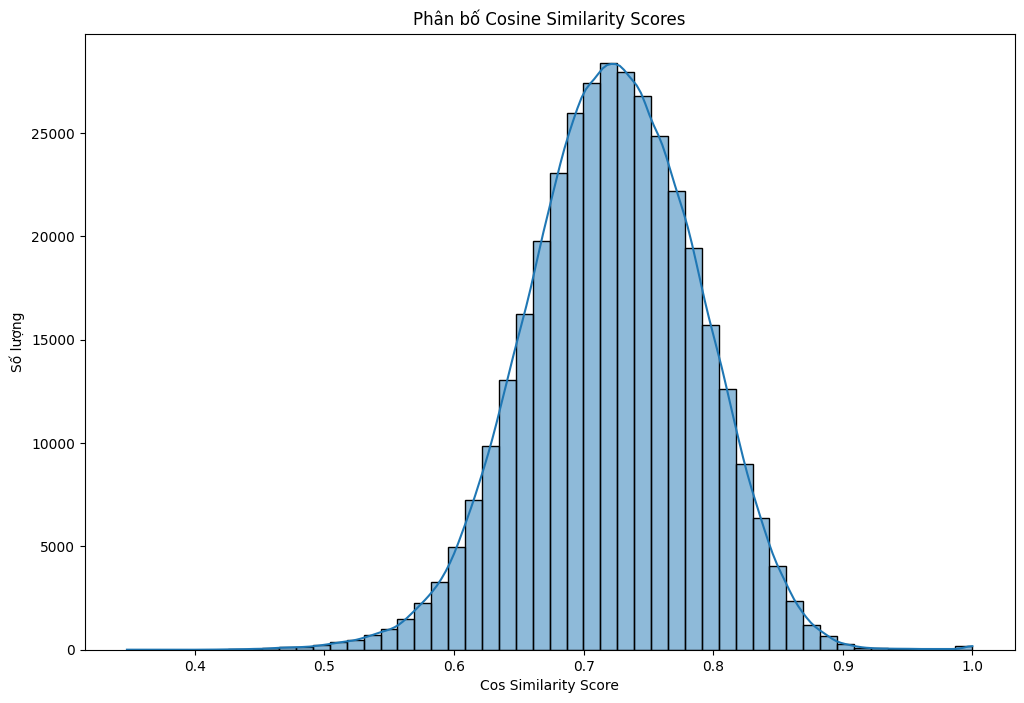

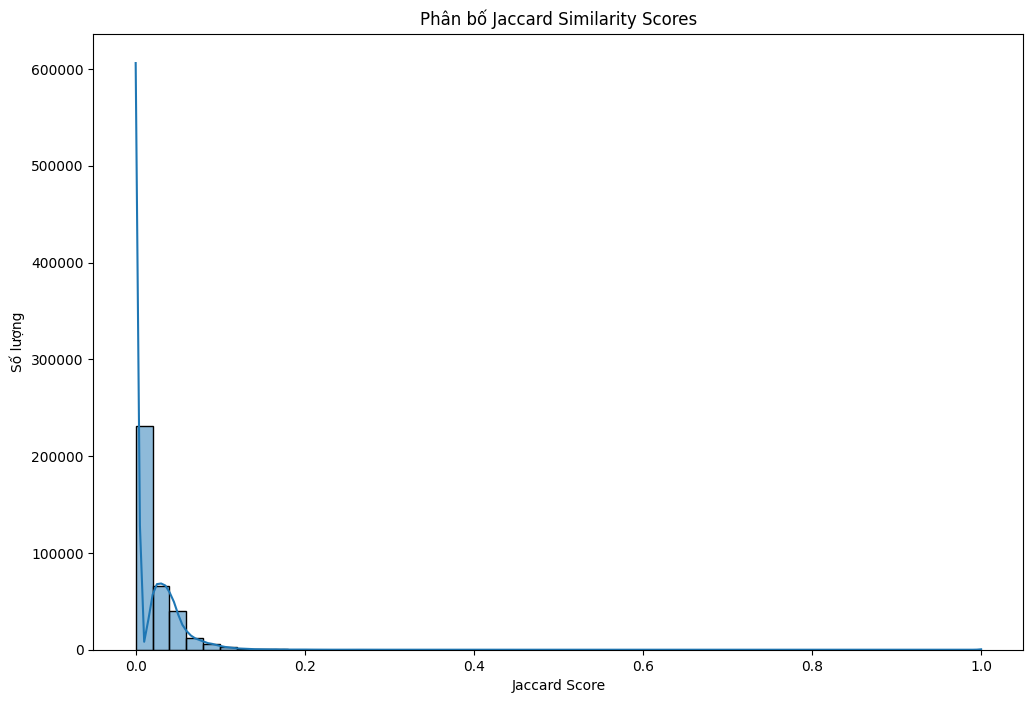

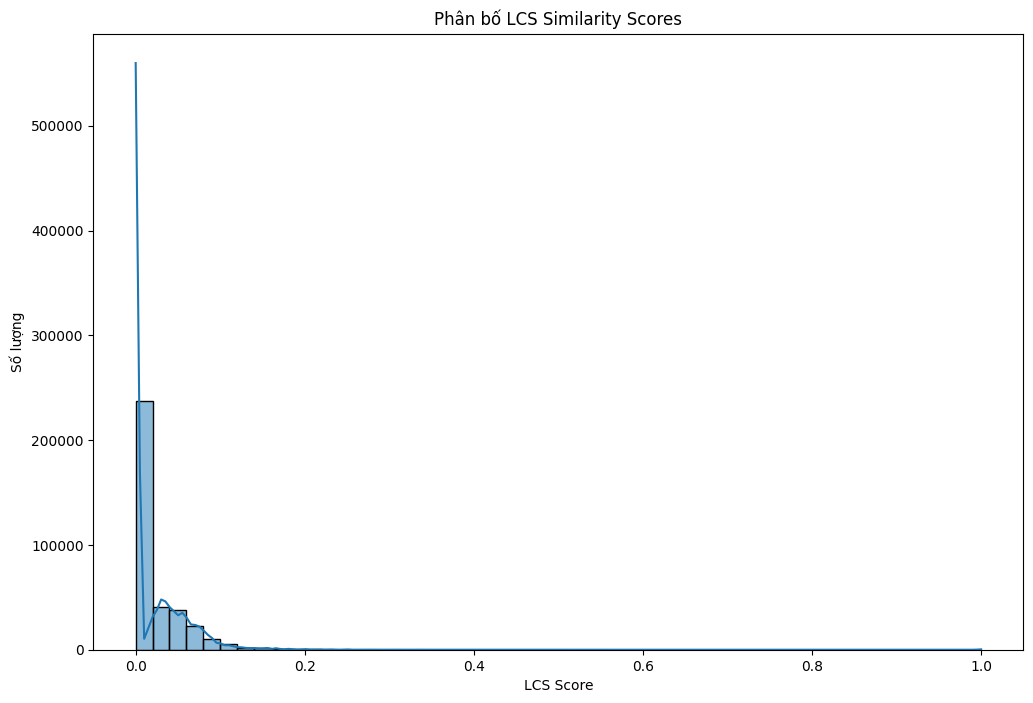

In [28]:
distribution_chart()

In [25]:
import numpy as np
from scipy.spatial.distance import jensenshannon

dist1_flat = []
for arr in cosine_sim_distribution:
  # print(arr[0][0])
  dist1_flat.append(arr[0][0])

def safe_jensenshannon_for_lists(dist1, dist2, epsilon=1e-10):
    # Convert to numpy arrays and handle potential issues
    dist1_array = np.array(dist1, dtype=float)
    dist2_array = np.array(dist2, dtype=float)


    # Add small epsilon to prevent zero probabilities
    dist1_safe = dist1_array + epsilon
    dist2_safe = dist2_array + epsilon

    # Normalize distributions
    dist1_norm = dist1_safe / np.sum(dist1_safe)
    dist2_norm = dist2_safe / np.sum(dist2_safe)

    # Ensure non-negative and sum to 1
    dist1_norm = np.maximum(dist1_norm, 0)
    dist2_norm = np.maximum(dist2_norm, 0)
    dist1_norm /= np.sum(dist1_norm)
    dist2_norm /= np.sum(dist2_norm)

    # Calculate Jensen-Shannon divergence
    try:
        js_distance = jensenshannon(dist1_norm, dist2_norm)
        return js_distance
    except Exception as e:
        print("Calculation error:", e)
        return None

# Usage
result = safe_jensenshannon_for_lists(dist1_flat, jaccard_distribution)
print("Jensen-Shannon Distance CosJac:", result)

result2 = safe_jensenshannon_for_lists(dist1_flat, lcs_distribution)
print("Jensen-Shannon Distance CosLCS:", result2)

result3 = safe_jensenshannon_for_lists(lcs_distribution, jaccard_distribution)
print("Jensen-Shannon Distance LCSJac:", result3)

print("Sum: ", (result + result2 + result3))
print("Main: ", (result + result2 + result3)/3)

Jensen-Shannon Distance CosJac: 0.5394582991653861
Jensen-Shannon Distance CosLCS: 0.5582679122373766
Jensen-Shannon Distance LCSJac: 0.18772935726466722
Sum:  1.2854555686674298
Main:  0.42848518955580994


**Build the Graph**

In [26]:
#Build the graph
def build_graph_for_layers(embeddings, all_sentences):
  #Cos-sim Graph
  cos_similarity_graph = []
  for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):  # Avoid redundant pairs (i.e., only upper triangle of the matrix)
        if cosine_similarity([embeddings[i]], [embeddings[j]]) >= 0.72:
          cos_similarity_graph.append((i, j, cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]))
  #Jaccard Graph
  jaccard_graph = []
  for i in range(len(all_sentences)):
      for j in range(i + 1, len(all_sentences)):
        if jaccard_similarity(all_sentences[i], all_sentences[j]) >= 0.02:
          jaccard_graph.append((i, j, jaccard_similarity(all_sentences[i], all_sentences[j])))
  #LCS Graph
  lcs_graph = []
  for i in range(len(all_sentences)):
      for j in range(i + 1, len(all_sentences)):
        if LCSubstr(all_sentences[i], all_sentences[j]) >= 0.02:
          lcs_graph.append((i, j, LCSubstr(all_sentences[i], all_sentences[j])))
  return cos_similarity_graph, jaccard_graph, lcs_graph


cos_similarity_graph, jaccard_graph, lcs_graph = build_graph_for_layers(embeddings, all_sentences)

In [27]:

def remove_common_keys(dict1, dict2):
    # Find common keys
    common_keys = set(dict1.keys()) & set(dict2.keys())
    
    # Remove common keys from both dictionaries
    for key in common_keys:
        del dict1[key]
        del dict2[key]
    
    return dict1, dict2

def find_adjacent(node_A, node_B, cosine_similarities):
# Identify adjacent nodes for A and B
  adjacent_to_A = {}
  for a, b, score in cosine_similarities:
        if a == node_A:
            adjacent_to_A[b] = score
        elif b == node_A:
            adjacent_to_A[a] = score
  try:
    adjacent_to_A.pop(node_B)
  except:
    pass
  adjacent_to_B = {}
  for a, b, score in cosine_similarities:
      if b == node_B:
          adjacent_to_B[a] = score
      elif a == node_B:
          adjacent_to_B[b] = score
  try:
    adjacent_to_B.pop(node_A)
  except:
    pass
  
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  #Loại bỏ các node bị trùng
  adjacent_to_A, adjacent_to_B = remove_common_keys(adjacent_to_A, adjacent_to_B)
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  # print("adjacent_to_A: ", dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True)))
  # print("adjacent_to_B: ", dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))
  # return adjacent_to_A, adjacent_to_B
  return list(dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True)))[:10], list(dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))[:10]

def find_sim_score(nodeA, nodeB, edges_list):
    # Find similarity score between two nodes from edges list
    for a, b, score in edges_list:
        if (a == nodeA and b == nodeB) or (a == nodeB and b == nodeA):
            return score
    return 0

#Cần sửa lại để đsung logic
def calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore):
  sum_weight = 0

  # Find common adjacent nodes between nodeA and nodeB
  # common_adj = set(adj_A).intersection(set(adj_B))
  # print("Common_node: ", common_adj)
  # for common_node in common_adj:
  #   adj_A.remove(common_node)
  #   adj_B.remove(common_node)
  # print("Sau remove: ", adj_A)
  # print("Sau remove: ", adj_B)

  for node_A_adj in adj_A:
      for node_B_adj in adj_B:
      # Calculate weight(C,D) = cos_sim(A,C) × cos_sim(B,D)
        weight = (find_sim_score(nodeA, node_A_adj, simScore) *
                find_sim_score(nodeB, node_B_adj, simScore))
        # print("Node_pair: ", node_A_adj, node_A_adj)
        # print("Weight: ", weight)
        sum_weight += weight

  return sum_weight

def calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore):
    sum_weighted = 0

    # Find common adjacent nodes between nodeA and nodeB
    # common_adj = set(adj_A).intersection(set(adj_B))
    # print("Common_node: ", common_adj)
    # for common_node in common_adj:
    #   adj_A.remove(common_node)
    #   adj_B.remove(common_node)
    # print("Sau remove: ", adj_A)
    # print("Sau remove: ", adj_B)    
    for node_A_adj in adj_A:
      for node_B_adj in adj_B:  
            # Get cosine similarity between the common adjacent nodes
            sim = find_sim_score(node_A_adj, node_B_adj, simScore)
            weight = (find_sim_score(nodeA, node_A_adj, simScore) * find_sim_score(nodeB, node_B_adj, simScore))
            # print("Node_pair: ", weight)
            # Calculate final weighted value
            weighted = sim * weight
            sum_weighted += weighted
    return sum_weighted


def calculate_equation15(nodeA, nodeB, adj_A, adj_B, simScore):
    # Get cos_sim(A,B) - the direct similarity between A and B
    cos_sim_AB = find_sim_score(nodeA, nodeB, simScore)

    # Calculate sum_wtd(A,B) using equation 17
    sum_wtd = calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weighted: ", sum_wtd)
    # Calculate sum_w_adj(A,B) using equation 16
    sum_w_adj = calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weight: ", sum_w_adj)
    # Final formula: (cos_sim(A,B) + sum_wtd(A,B)) / (1 + sum_w_adj(A,B))
    similarity = (cos_sim_AB + sum_wtd) / (1 + sum_w_adj)

    return similarity

def local_similarity(nodeA, nodeB, sim_list):

  adjacent_to_A, adjacent_to_B = find_adjacent(nodeA,nodeB, sim_list)
  # adjacent_to_1_jackcard, adjacent_to_2_jackcard = find_adjacent(nodeA,nodeB, jaccard_similarities)

  final_similarity = calculate_equation15(nodeA, nodeB, adjacent_to_A, adjacent_to_B, sim_list)
  # final_similarity2 = calculate_equation15(nodeA, nodeB, adjacent_to_1, adjacent_to_2, jaccard_similarities)

  # print(f"Final similarity score cosine between nodes {nodeA} and {nodeB}: {final_similarity}")
  # print(f"Final similarity score jaccard between nodes {nodeA} and {nodeB}: {final_similarity2}")
  return final_similarity

def overall_sentence_similarity(localsim:list, jsd_sum, jsd_main):
  sum = 0
  mul= 1
  for local in localsim[1:]:
    # print(local)
    sum = sum + local
    mul = mul * local

  # result =  (jsd_sum * localsim[0] ) + (mul/(jsd_main*sum))
  # result =  localsim[0] + (mul/(jsd_main*sum))
  # print("mul/(jsd_sumsum: ", (mul/(jsd_main*sum)))
  result =  (jsd_main * localsim[0]) + (mul/(jsd_sum*sum))
  # result = mul/(jsd_main*sum)

  print(result)
  # 1.25653205089 * 
  # for i in localsim:
  #   sum = sum + i
  #   mul = mul * i
  # # print("SUM: ", sum)
  # # print("MUL: ", mul)
  # # print(result)
  # # result = (jsd*sum)
  # return  result if result < 1.0 else localsim[0]
  return result

def get_local_sim_from_jaccard_layer():
  data_jaccard = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600   
    data_jaccard[sentence_pair_index] = local_similarity(nodeA, nodeB, jaccard_graph) 
  with open('./jaccard_layer_local_sim_llama.json', 'w') as file:
    json.dump(data_jaccard, file)

def get_local_sim_from_lcs_layer():
  data_lcs = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600
    data_lcs[sentence_pair_index] = local_similarity(nodeA, nodeB, lcs_graph) 
  with open('./lcs_layer_local_sim_llama.json', 'w') as file:
    json.dump(data_lcs, file)

def get_local_sim_from_cos_layer():
  data_cos = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600
    # print(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
    data_cos[sentence_pair_index ] = float(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
  with open('./cos_layer_local_sim_llama.json', 'w') as file:
    json.dump(data_cos, file)

# get_local_sim_from_lcs_layer()


In [129]:
print(local_similarity(0, 600, cos_similarity_graph))
print(find_sim_score(3, 603, cos_similarity_graph))

0.11042981734310495
0.8178506214320721


In [ ]:
# get_local_sim_from_cos_layer()
# get_local_sim_from_lcs_layer()
# get_local_sim_from_jaccard_layer()

In [29]:
def get_overall_sim_from_all_layers():
    calculated_sim_from_all_graph = []
    with open('./cos_layer_local_sim_llama.json', 'r') as file:
        cos_sim_local = json.load(file)
        # print(cos_sim_local)
    with open('./jaccard_layer_local_sim_llama.json', 'r') as file:
        jaccard_sim_local = json.load(file)
        # print(jaccard_sim_local)
    with open('./lcs_layer_local_sim_llama.json', 'r') as file:
        lcs_sim_local = json.load(file)
        # print(lcs_sim_local)

    #Lấy thông số từ việc tính jsd giữa các layer phía trên

    jsd_main = 0.42848518955580994
    jsd_sum = 1.2854555686674298
    # calculated_sim_from_all_graph = overall_sentence_similarity([find_sim_score(0, 600, cos_similarity_graph), 0.17710259555547728, jaccard_sim_local["0"], lcs_sim_local["0"]],jsd_sum, jsd_main)
    # return calculated_sim_from_all_graph
    for sentence_pair_index in range(0,600):
        # print("idhbfgsliufg", cos_sim_local[str(sentence_pair_index)])
        calculated_sim_from_all_graph.append(overall_sentence_similarity([find_sim_score(sentence_pair_index, sentence_pair_index +600, cos_similarity_graph), cos_sim_local[str(sentence_pair_index)], jaccard_sim_local[str(sentence_pair_index)], lcs_sim_local[str(sentence_pair_index)]],jsd_sum, jsd_main))
    return calculated_sim_from_all_graph

overall_sim_graph = get_overall_sim_from_all_layers()
# print(overall_sim_graph)

0.39634916269564074
0.4530885039676508
0.43232692641518994
0.35245455746467835
0.4220033024063476
0.4307771081150351
0.38070897574161894
0.3831512968937648
0.435536682089034
0.4115002511879155
0.40566191546355185
0.3902458729461032
0.44155470267169294
0.45756353830187707
0.45142269918739153
0.3693611906997858
0.6064522046368855
0.48680515819922376
0.364864418459833
0.4717382222599761
0.43244059662500434
0.37459976358730745
0.5355043333698406
0.3978253160664663
0.4384747229926843
0.3916988295709453
0.3516042840273284
0.4474339698149665
0.34980560044010683
0.4220459707131888
0.43153934734466554
0.3688837599944731
0.3775016866103107
0.42565541439248306
0.37576781711301116
0.4253725500693363
0.38064155878522776
0.3560300606514509
0.4783628731367409
0.42119445101903535
0.3594734472375088
0.47276010942615976
0.6877966285959651
0.4007468682569377
0.3928485313073335
0.43554188104390423
0.389129525231369
0.3491711843044504
0.37075374943032824
0.6065526810526493
0.5192814242981045
0.687796628595

In [30]:
#Pearson score với baseline model embedding
from scipy import stats
calculated_sim_baseline = []
for i in range(0, 600):
 calculated_sim_baseline.append(cosine_similarity([embeddings[i]], [embeddings[i+600]])[0][0])
pearson_correlation, p_value = stats.pearsonr(calculated_sim_baseline, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.6213128662174294
P-value: 2.371483762773133e-65


In [128]:
print(calculated_sim_baseline[:20])
print(ground_truth[:10])

[np.float64(0.9102838451601913), np.float64(0.9952852088563865), np.float64(0.9698038506129658), np.float64(0.8178506214320721), np.float64(0.9678282218947956), np.float64(0.9531954526928442), np.float64(0.8862623507546764), np.float64(0.8936639218481914), np.float64(0.9698795834417772), np.float64(0.9446700893389545), np.float64(0.9380028351966372), np.float64(0.9092770630919065), np.float64(0.9910069827362739), np.float64(0.9624585623960836), np.float64(0.9770583367218628), np.float64(0.8585899248374824), np.float64(0.9911303745237574), np.float64(0.9928826976004325), np.float64(0.848982982264814), np.float64(0.9901467046432824)]
[0.6666666666666666, 0.8541666666666666, 0.3958333333333333, 0.125, 0.5208333333333334, 0.6875, 0.041666666666666664, 0.08333333333333333, 0.4375, 0.7291666666666666]


In [31]:
from scipy import stats
# print(ground_truth)
# print(calculated_sim_from_all_graph)
# Alternatively
pearson_correlation, p_value = stats.pearsonr(overall_sim_graph, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.5181090427563082
P-value: 1.6155016119456545e-42


In [135]:
print(overall_sim_graph[:10])
print(ground_truth[:10])

[np.float64(0.5042021978298137), np.float64(0.5600672592991914), np.float64(0.5518069053373037), np.float64(0.45101587599016657), np.float64(0.5550574028660279), np.float64(0.554919955305647), np.float64(0.4879018772056361), np.float64(0.4907408146046239), np.float64(0.5794358128828443), np.float64(0.5503647666555135)]
[0.6666666666666666, 0.8541666666666666, 0.3958333333333333, 0.125, 0.5208333333333334, 0.6875, 0.041666666666666664, 0.08333333333333333, 0.4375, 0.7291666666666666]


In [141]:
print(normalized_embeddings[0])

print(cosine_similarity([normalized_embeddings[i]], [normalized_embeddings[i+600]])[0][0])

[-0.00311089  0.00121372  0.00612751 ...  0.00018486 -0.00405358
  0.0057033 ]
0.9381925583521766
